# The usual CO2 example

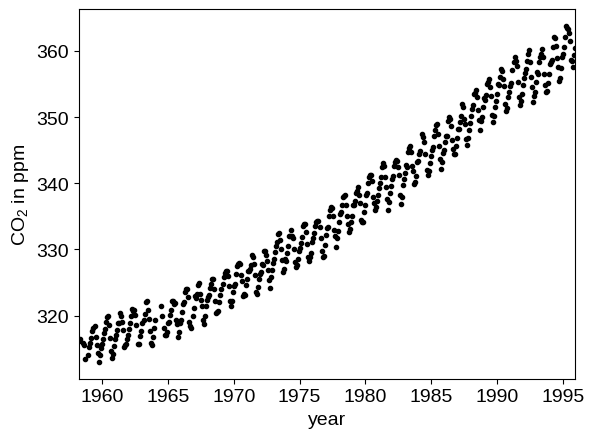

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.datasets import co2

data = co2.load_pandas().data
t = 2000 + (np.array(data.index.to_julian_date()) - 2451545.0) / 365.25
y = np.array(data.co2)
m = np.isfinite(t) & np.isfinite(y) & (t < 1996)
t, y = t[m][::4], y[m][::4]

plt.plot(t, y, ".k")
plt.xlim(t.min(), t.max())
plt.xlabel("year")
_ = plt.ylabel("CO$_2$ in ppm")

In [2]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp

from tinygp import kernels, GaussianProcess


def build_kernel(theta):
    k1 = theta[0] ** 2 * kernels.ExpSquared(theta[1])
    k2 = theta[2] ** 2 * kernels.ExpSquared(theta[3]) * kernels.ExpSineSquared(theta[4], gamma=theta[5])
    k3 = theta[6] ** 2 * kernels.RationalQuadratic(theta[7], alpha=theta[8])
    k4 = theta[9] ** 2 * kernels.ExpSquared(theta[10])
    return k1 + k2 + k3 + k4


def build_gp(theta, X):
    return GaussianProcess(build_kernel(jnp.exp(theta)), X, diag=jnp.exp(2 * theta[11]), mean=theta[12])


def neg_log_likelihood(theta, X, y):
    gp = build_gp(theta, X)
    return -gp.condition(y)

theta_init = np.append(np.log([66.0, 67.0, 2.4, 90.0, 1.0, 4.3, 0.66, 1.2, 0.78, 0.18, 1.6, 0.19]), 340.0)
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))
print(f"Initial negative log likelihood: {obj(theta_init, t, y)[0]}")

Initial negative log likelihood: 618.4282067615695


In [3]:
from scipy.optimize import minimize
soln = minimize(obj, theta_init, jac=True, args=(t, y))
print(f"Final negative log likelihood: {soln.fun}")

Final negative log likelihood: 296.5983250240681


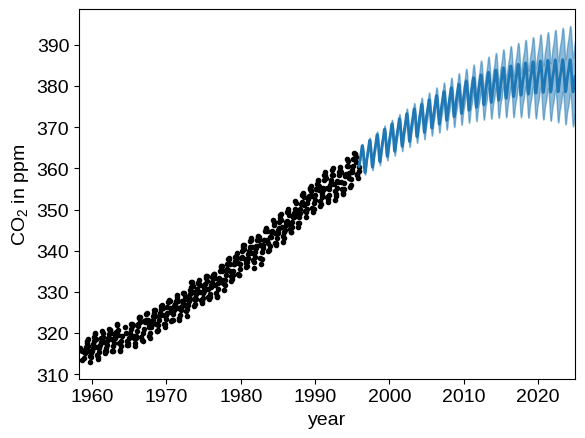

In [4]:
x = np.linspace(max(t), 2025, 2000)
gp = build_gp(soln.x, t)
gp.condition(y)
mu, var = gp.predict(x, return_var=True)

plt.plot(t, y, ".k")
plt.fill_between(x, mu + np.sqrt(var), mu - np.sqrt(var), color="C0", alpha=0.5)
plt.plot(x, mu, color="C0", lw=2)

plt.xlim(t.min(), 2025)
plt.xlabel("year")
_ = plt.ylabel("CO$_2$ in ppm")